In [1]:
# 讀取模型

from torchsummary import summary
from models.SFMCNN import SFMCNN
from models.RGB_SFMCNN import RGB_SFMCNN
from models.RGB_SFMCNN_V2 import RGB_SFMCNN_V2
from dataloader import get_dataloader
from config import *

with torch.no_grad():
    # Load Dataset
    train_dataloader, test_dataloader = get_dataloader(dataset=config['dataset'], root=config['root'] + '/data/',
                                                       batch_size=config['batch_size'],
                                                       input_size=config['input_shape'])
    images, labels = torch.tensor([]), torch.tensor([])
    for batch in train_dataloader:
        imgs, lbls = batch
        images = torch.cat((images, imgs))
        labels = torch.cat((labels, lbls))
    print(images.shape, labels.shape)

    # Load Model
    models = {'SFMCNN': SFMCNN, 'RGB_SFMCNN': RGB_SFMCNN, 'RGB_SFMCNN_V2': RGB_SFMCNN_V2}
    checkpoint_filename = 'RGB_SFMCNN_V2_best'
    checkpoint = torch.load(f'./pth/{config["dataset"]}_pth/{checkpoint_filename}.pth', weights_only=True)
    model = models[arch['name']](**dict(config['model']['args']))
    model.load_state_dict(checkpoint['model_weights'])
    model.cpu()
    model.eval()
    summary(model, input_size=(config['model']['args']['in_channels'], *config['input_shape']), device='cpu')
    print(model)


Code/runs/train/exp
torch.Size([60000, 3, 28, 28]) torch.Size([60000, 30])
triangle
cReLU_percent
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        RGB_Conv2d-1             [-1, 30, 6, 6]               0
        RGB_Conv2d-2             [-1, 30, 6, 6]               0
          triangle-3             [-1, 30, 6, 6]               0
          triangle-4             [-1, 30, 6, 6]               0
     cReLU_percent-5             [-1, 30, 6, 6]               0
     cReLU_percent-6             [-1, 30, 6, 6]               0
               SFM-7             [-1, 30, 3, 6]               0
        RBF_Conv2d-8            [-1, 225, 3, 6]           6,750
     cReLU_percent-9            [-1, 225, 3, 6]               0
              SFM-10            [-1, 225, 3, 3]               0
       RBF_Conv2d-11            [-1, 625, 3, 3]         140,625
    cReLU_percent-12            [-1, 625, 3, 3]               0
     

In [2]:
# 可解釋性圖繪製方法
import os
import warnings

from utils import plot_combine_images

warnings.filterwarnings('ignore')
from torchvision import transforms

from pytorch_grad_cam import run_dff_on_image, GradCAM, HiResCAM, GradCAMPlusPlus, GradCAMElementWise, XGradCAM, \
    AblationCAM, ScoreCAM, EigenCAM, EigenGradCAM, LayerCAM, FullGrad, DeepFeatureFactorization, KPCA_CAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional
import matplotlib.pyplot as plt

""" Model wrapper to return a tensor"""


class ModelWrapper(torch.nn.Module):
    """將 Huggingface 模型包裝為返回張量的模型"""
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self.model(inputs)


""" Helper function to run GradCAM on an image and create a visualization.
    (note to myself: this is probably useful enough to move into the package)
    If several targets are passed in targets_for_gradcam,
    e.g different categories,
    a visualization for each of them will be created.

"""
def generate_cam_visualization(
    model: torch.nn.Module,
    target_layer: torch.nn.Module,
    cam_targets: List[Callable],
    transform: Optional[Callable],
    input_tensor: torch.Tensor,
    input_image: Image.Image,
    cam_method: Callable = GradCAM
) -> np.ndarray:
    """生成 CAM 可視化結果
    
    Args:
        model: 目標模型
        target_layer: 目標層
        cam_targets: CAM 目標列表
        transform: 形狀轉換函數
        input_tensor: 輸入張量
        input_image: 輸入圖像
        cam_method: CAM 方法
        
    Returns:
        包含所有目標的 CAM 可視化結果
    """
    wrapped_model = ModelWrapper(model)
    
    with cam_method(
        model=wrapped_model,
        target_layers=[target_layer],
        reshape_transform=transform
    ) as cam:
        batch_tensor = input_tensor[None, :].repeat(len(cam_targets), 1, 1, 1)
        cam_results = cam(input_tensor=batch_tensor, targets=cam_targets)
        
        visualizations = []
        for grayscale_cam in cam_results:
            vis = show_cam_on_image(
                np.float32(input_image) / 255,
                grayscale_cam,
                use_rgb=True
            )
            vis = cv2.resize(vis, (vis.shape[1] * 2, vis.shape[0] * 2))
            visualizations.append(vis)
            
        return np.hstack(visualizations)


def get_target_layers(model: torch.nn.Module) -> dict:
    """獲取需要分析的目標層
    
    Args:
        model: 目標模型
        
    Returns:
        包含所有目標層的字典
    """
    return {
        'RGB_convs_0': model.RGB_convs[1],
        'RGB_convs_1': model.RGB_convs[2][1],
        'RGB_convs_2': model.RGB_convs[3],
        'Gray_convs_0': model.Gray_convs[0][1],
        'Gray_convs_1': model.Gray_convs[2][1],
        'Gray_convs_2': model.Gray_convs[3]
    }



def visualize_heatmap(model, layers, image, img_tensor, label, method: Callable = GradCAM):
    """生成可視化結果

        Args:
            model: 目標模型
            layers: 目標層字典
            image: 輸入圖像
            img_tensor: 輸入圖片 tensor
            label: 目標標籤
            method: CAM 方法
        """
    imgs = {}
    # 添加原始圖像的figure
    fig_raw = plt.figure(figsize=(6, 6))
    plt.imshow(img_tensor.permute(1, 2, 0).cpu().numpy())  # 確保數據是numpy數組
    plt.axis('off')
    plt.draw()
    plt.close(fig_raw)
    imgs['raw'] = fig_raw

    targets_for_gradcam = [ClassifierOutputTarget(label)]
    for layer in layers:
        target_layer = layers[layer]

        cam_img = generate_cam_visualization(model, target_layer, targets_for_gradcam, None, img_tensor, image, method)

        # 確保cam_img是正確的numpy數組
        if isinstance(cam_img, torch.Tensor):
            cam_img = cam_img.cpu().numpy()

        fig = plt.figure(figsize=(6, 6))

        plt.imshow(cam_img)
        plt.axis('off')
        plt.draw()
        plt.close(fig)

        imgs[layer] = fig

    return imgs


def visualize_all_heatmap(
    model: torch.nn.Module,
    target_layers: dict,
    image: torch.Tensor,
    label: int,
    output_dir: str,
    cam_methods: List[Callable]
) -> None:
    """為所有 CAM 方法生成可視化結果
    
    Args:
        model: 目標模型
        target_layers: 目標層字典
        image: 輸入圖像
        label: 目標標籤
        output_dir: 輸出目錄
        cam_methods: CAM 方法列表
    """
    heatmap_dir = os.path.join(output_dir, 'heatmap')
    os.makedirs(heatmap_dir, exist_ok=True)
    
    pil_image = transforms.ToPILImage()(image)
    img_tensor = transforms.ToTensor()(pil_image)
    
    for method in cam_methods:
        try:
            print(f"\n使用方法: {method.__name__}")
            visualizations = visualize_heatmap(
                model=model,
                layers=target_layers,
                image=pil_image,
                img_tensor=img_tensor,
                label=label,
                method=method
            )
            
            output_path = os.path.join(heatmap_dir, method.__name__)
            plot_combine_images(visualizations, output_path, show=True)
            
        except Exception as e:
            print(f"方法 {method.__name__} 執行失敗: {str(e)}")

In [4]:
# 要繪製的模型層

heatmap_layers = get_target_layers(model)
heatmap_layers

{'RGB_convs_0': SFM(
   filter=(2, 1), alpha=[[1. ]
    [0.4]]
 ),
 'RGB_convs_1': cReLU_percent(percent=0.4000000059604645),
 'RGB_convs_2': Sequential(
   (0): RBF_Conv2d(initial = kaiming, weight shape = (625, 225, 1, 1))
   (1): cReLU_percent(percent=0.5)
 ),
 'Gray_convs_0': cReLU_percent(percent=0.30000001192092896),
 'Gray_convs_1': cReLU_percent(percent=0.4000000059604645),
 'Gray_convs_2': Sequential(
   (0): RBF_Conv2d(initial = kaiming, weight shape = (1225, 625, 1, 1))
   (1): cReLU_percent(percent=0.5)
 )}

image<class 'torch.Tensor'>

使用方法: GradCAM


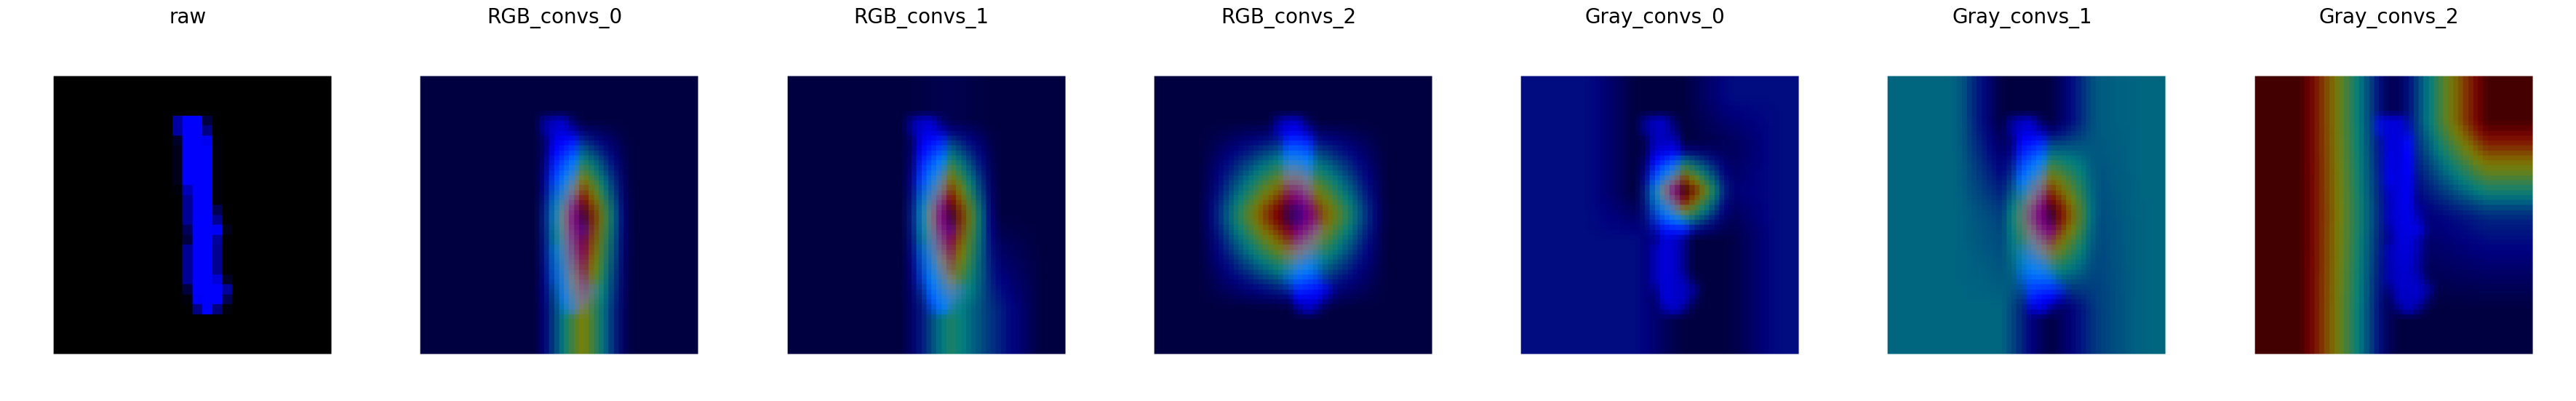


使用方法: HiResCAM


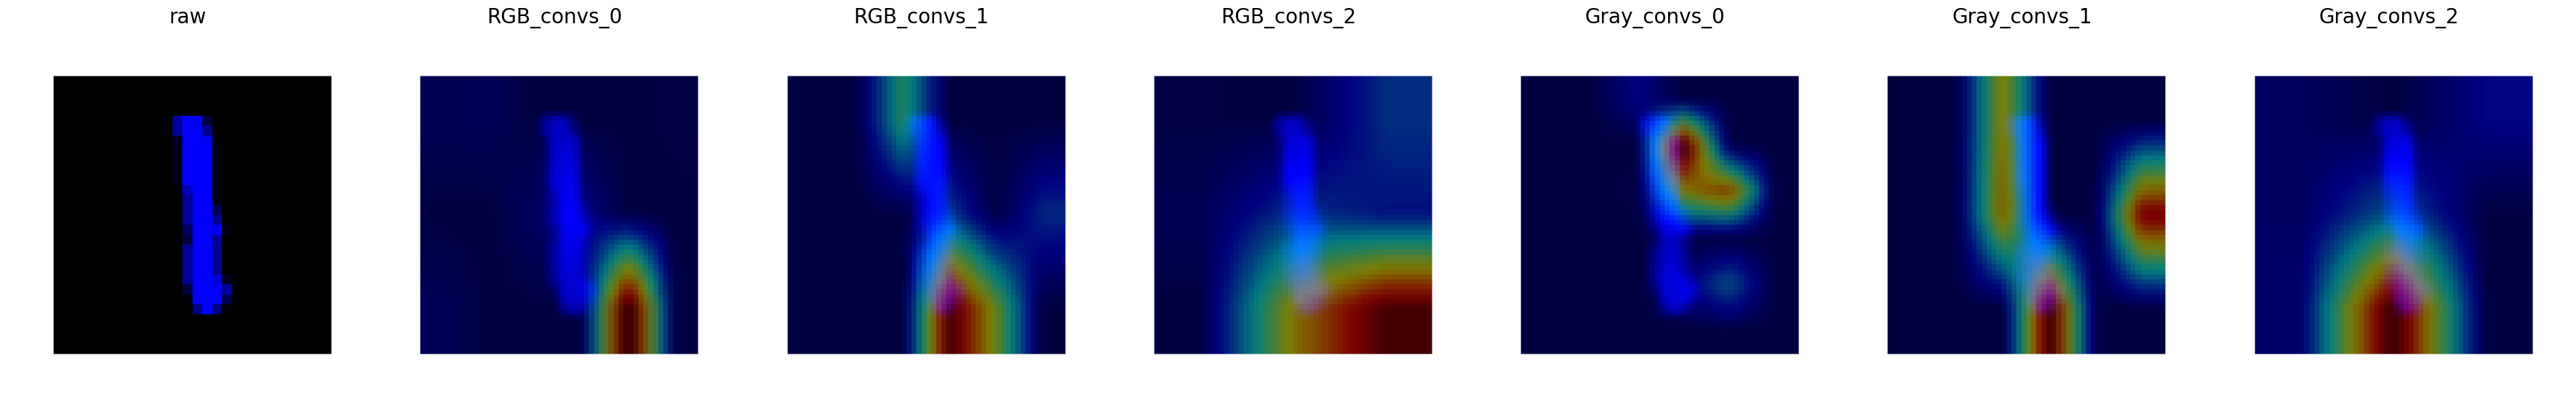


使用方法: GradCAMPlusPlus


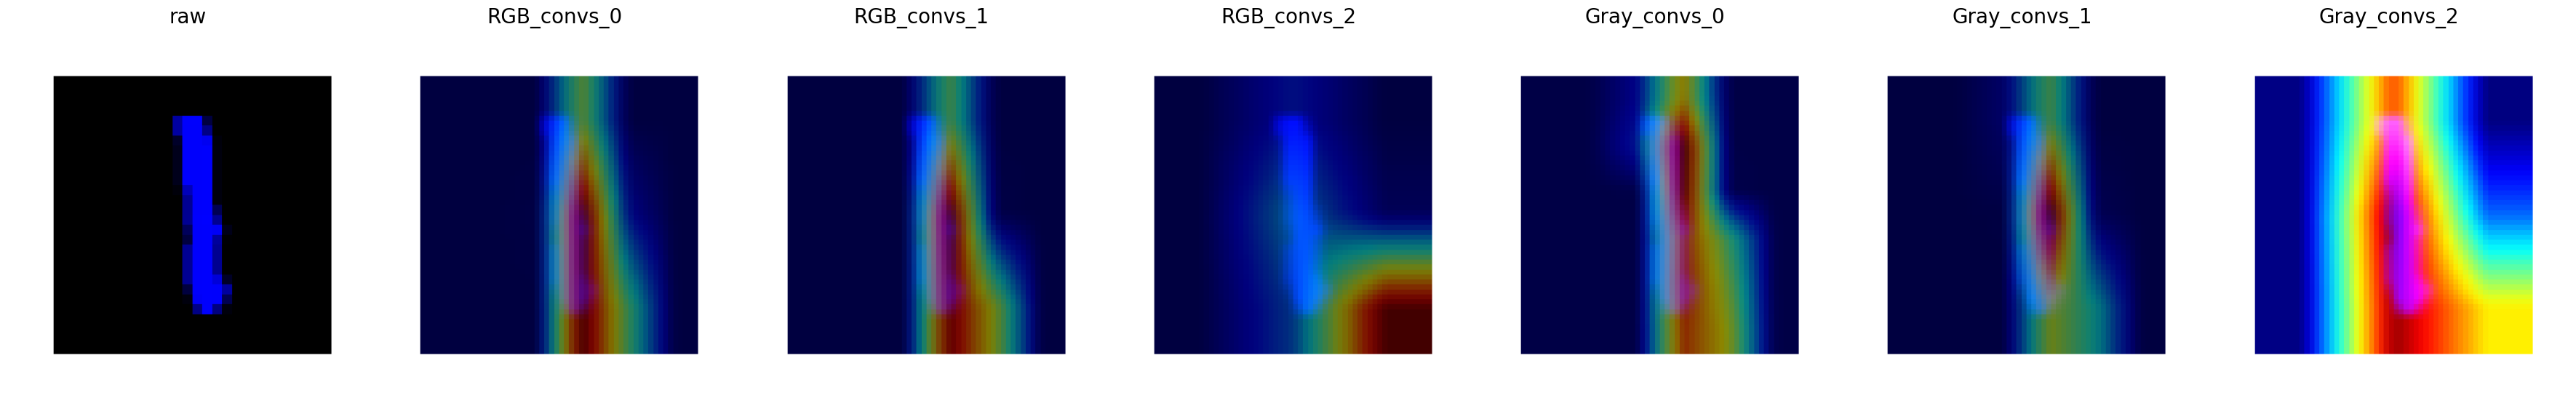


使用方法: GradCAMElementWise


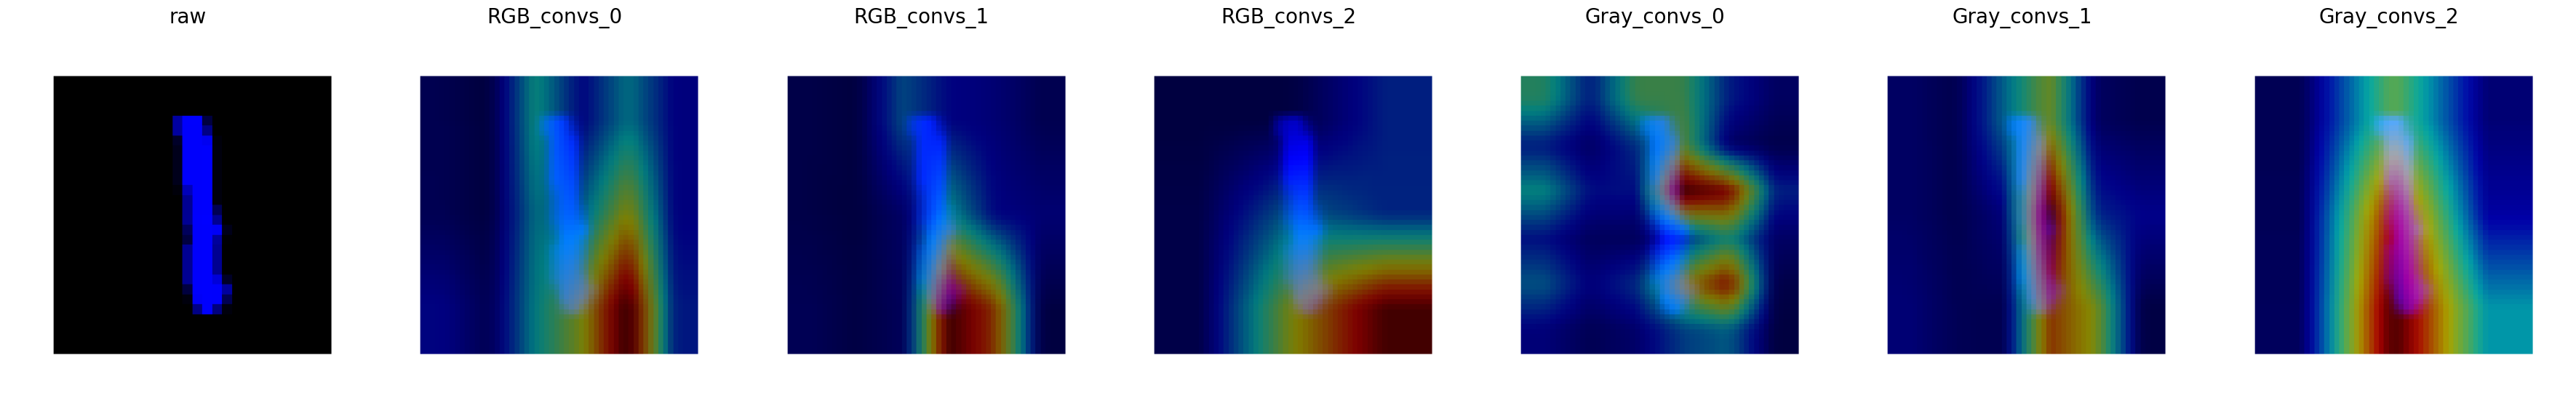


使用方法: XGradCAM


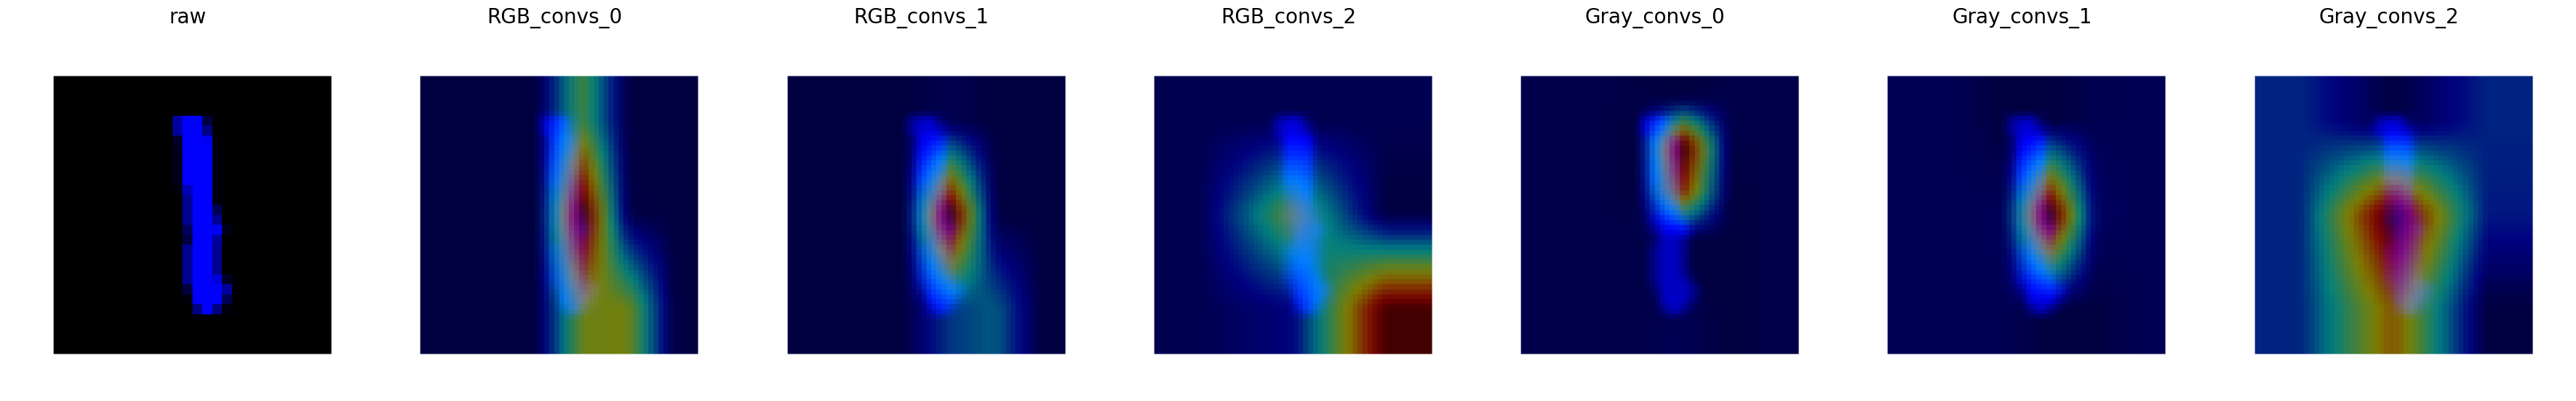


使用方法: AblationCAM


100%|██████████| 39/39 [00:01<00:00, 36.49it/s]


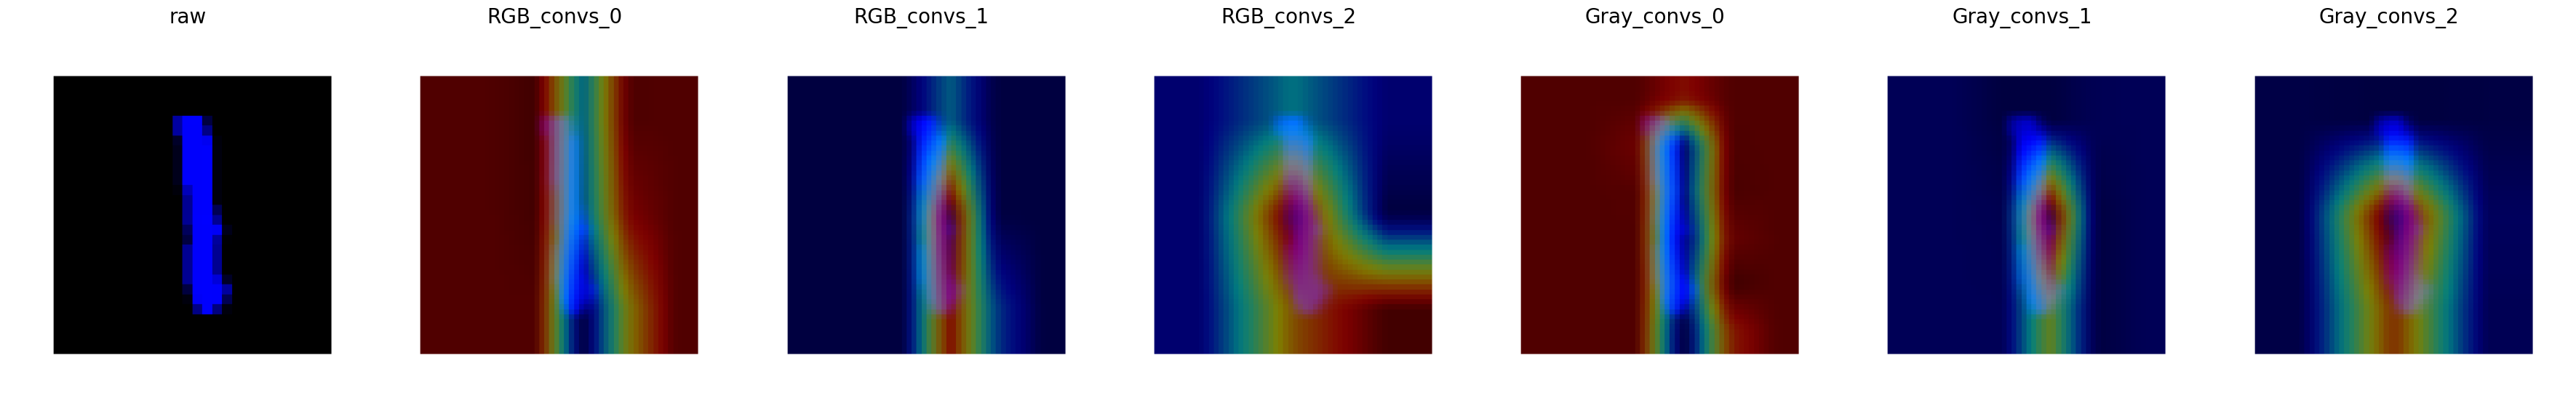


使用方法: ScoreCAM


100%|██████████| 77/77 [00:01<00:00, 42.45it/s]


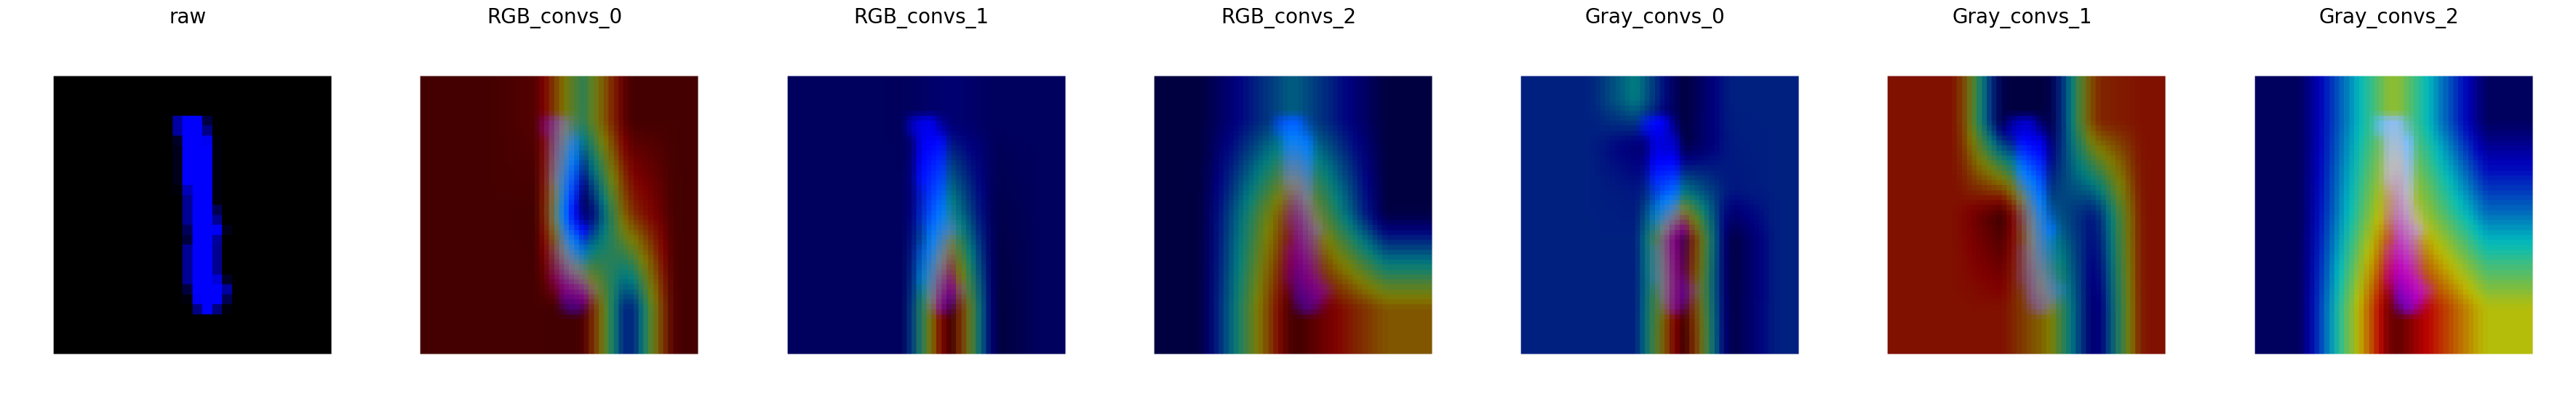


使用方法: EigenCAM


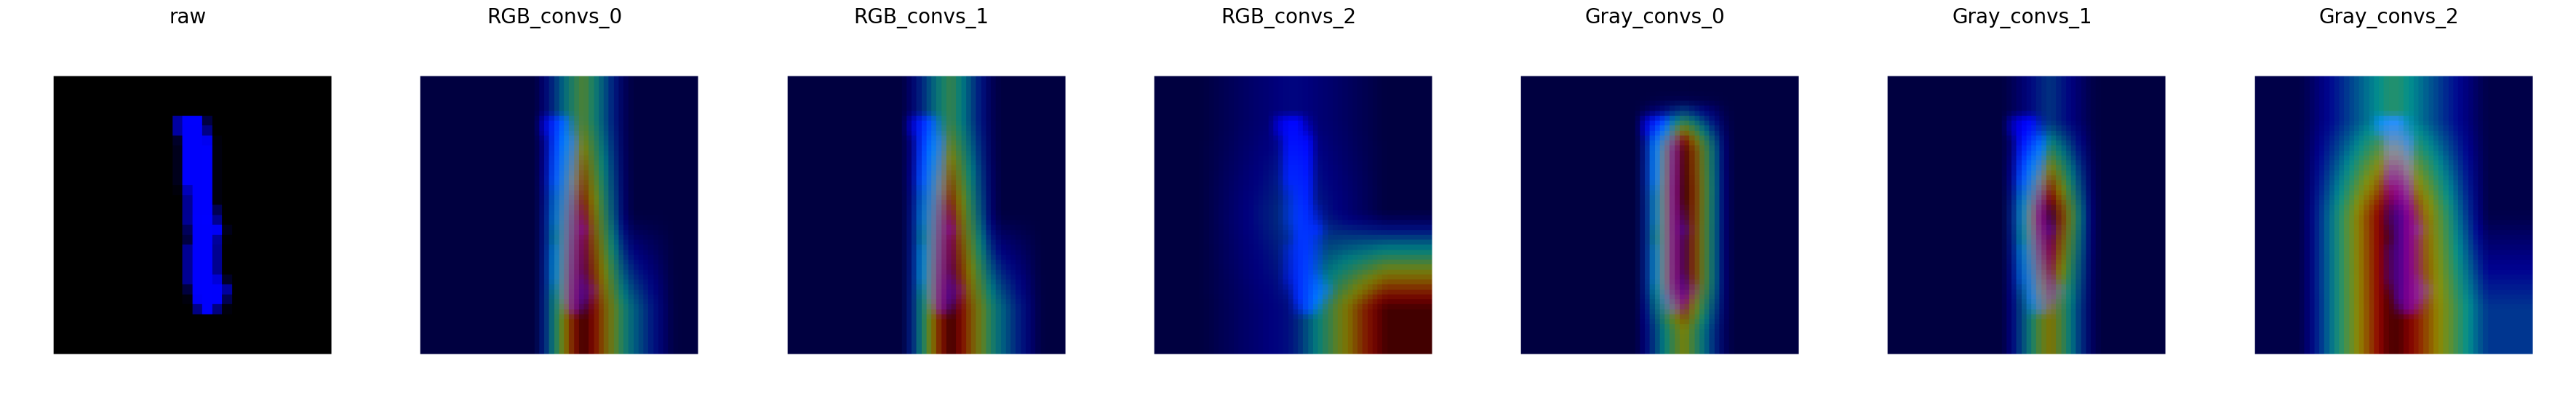


使用方法: EigenGradCAM


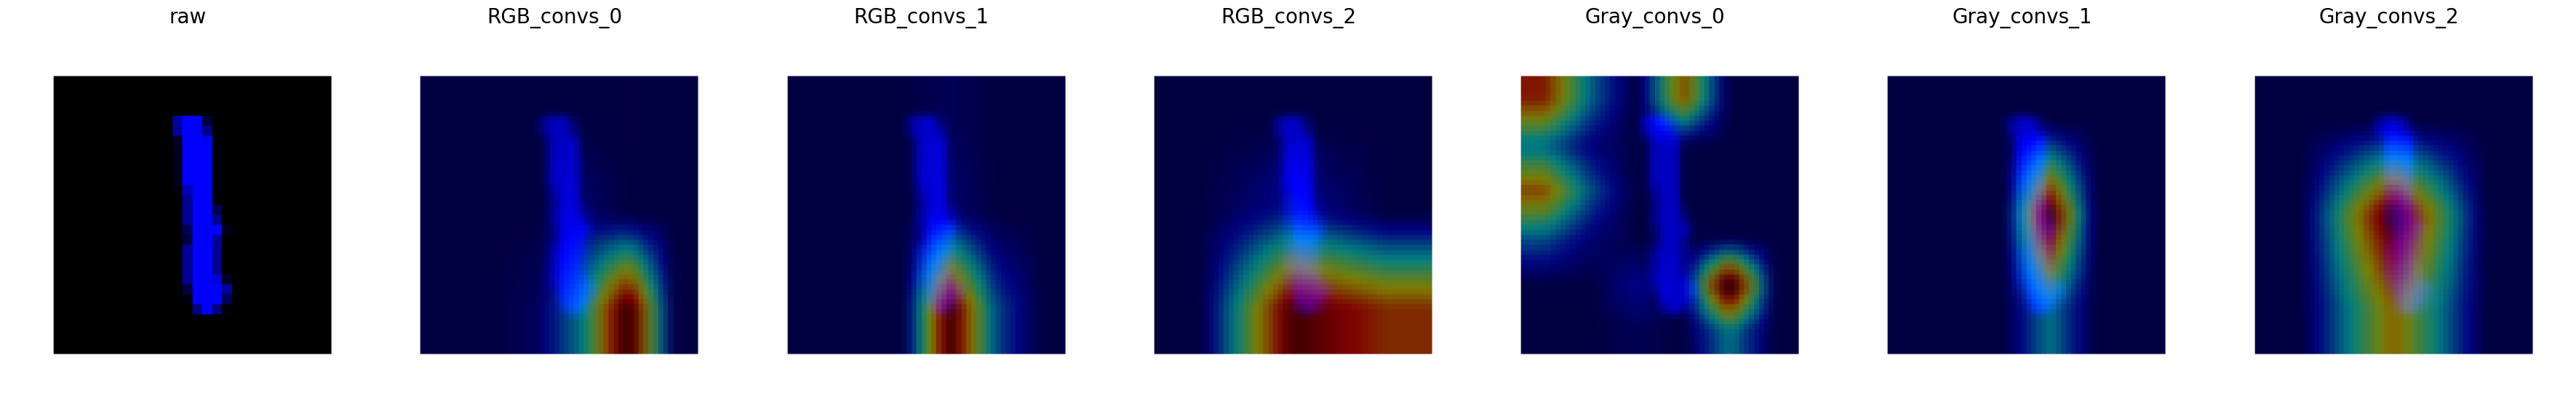


使用方法: LayerCAM


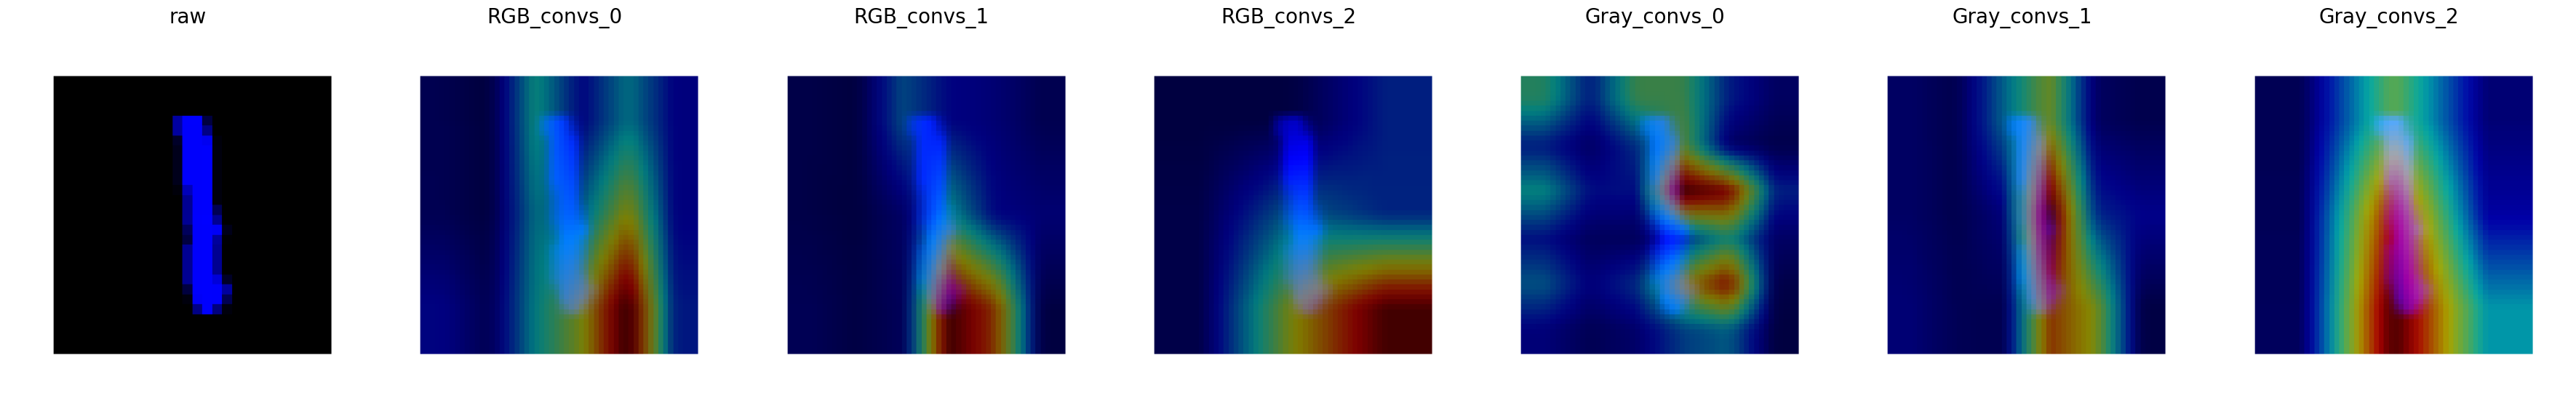


使用方法: KPCA_CAM


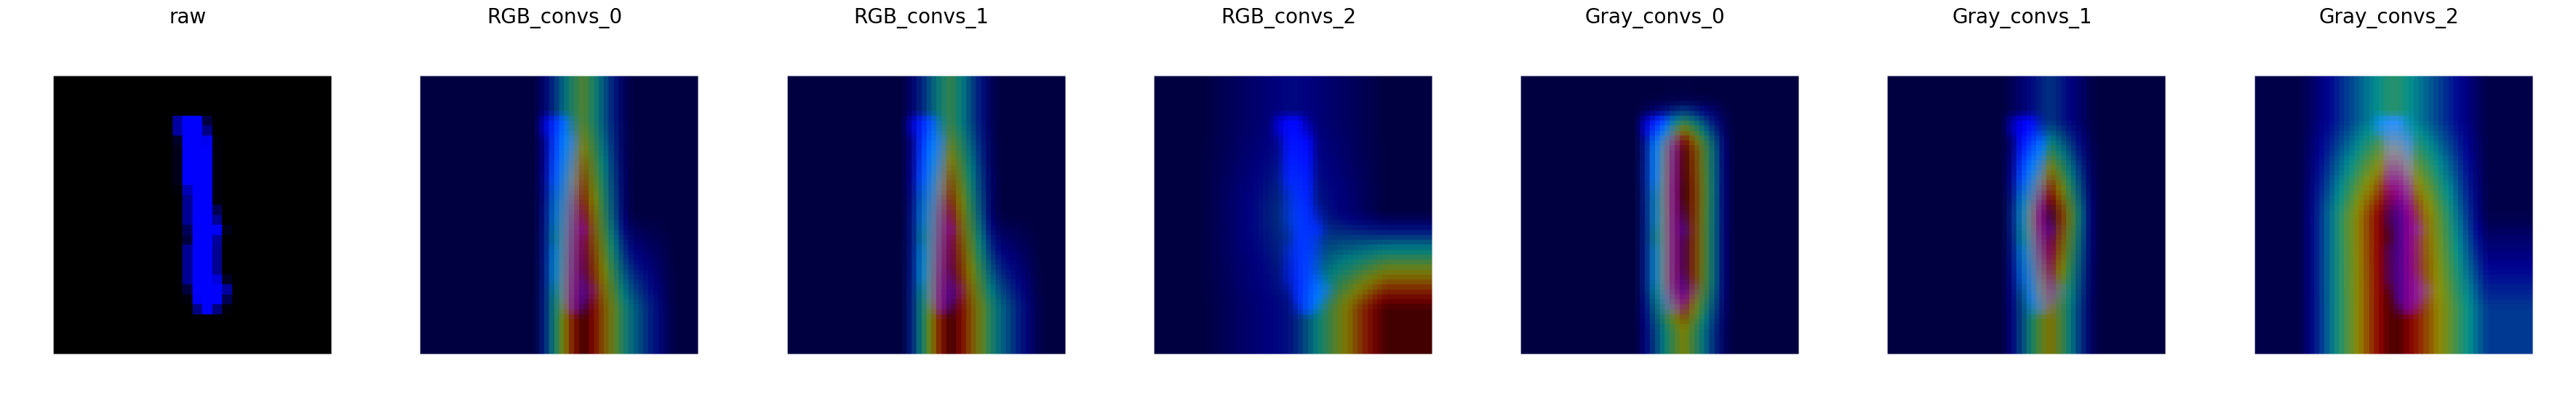

image<class 'torch.Tensor'>

使用方法: GradCAM


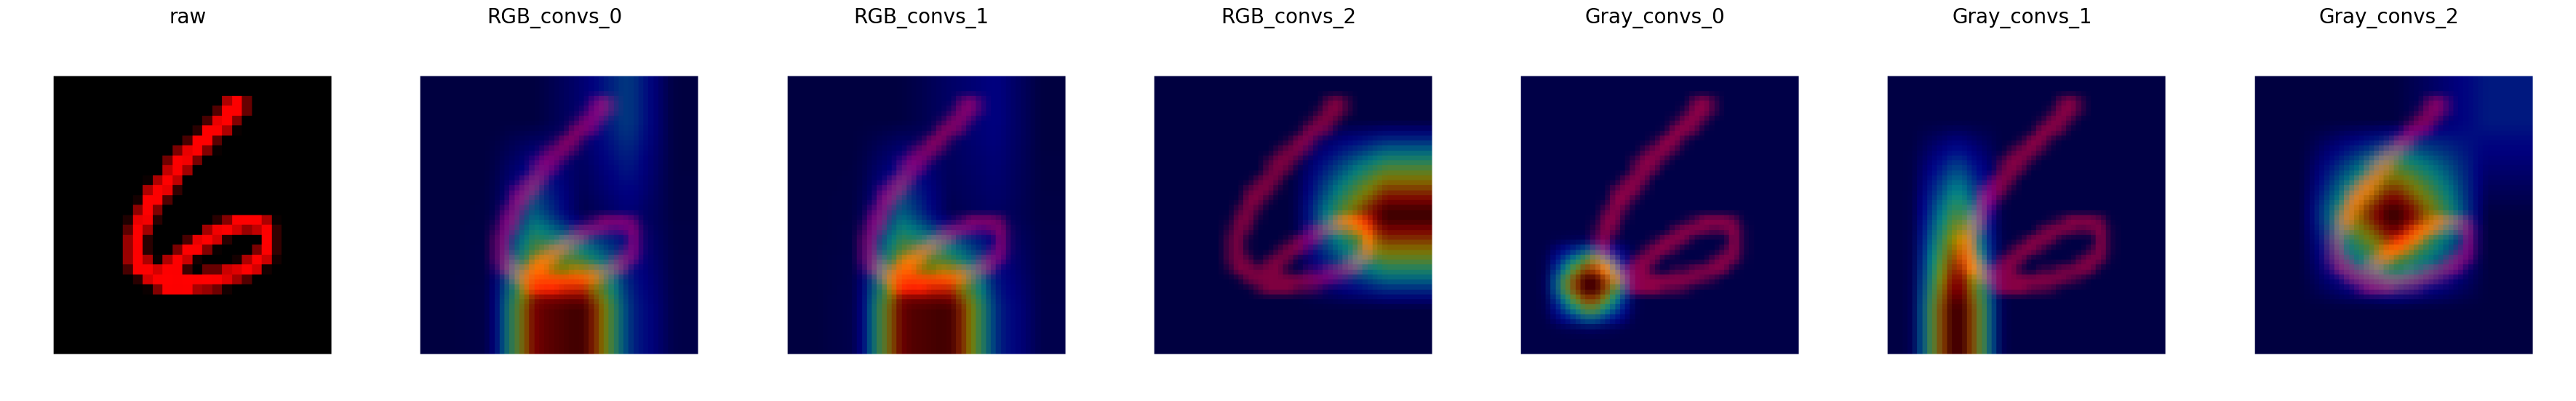


使用方法: HiResCAM


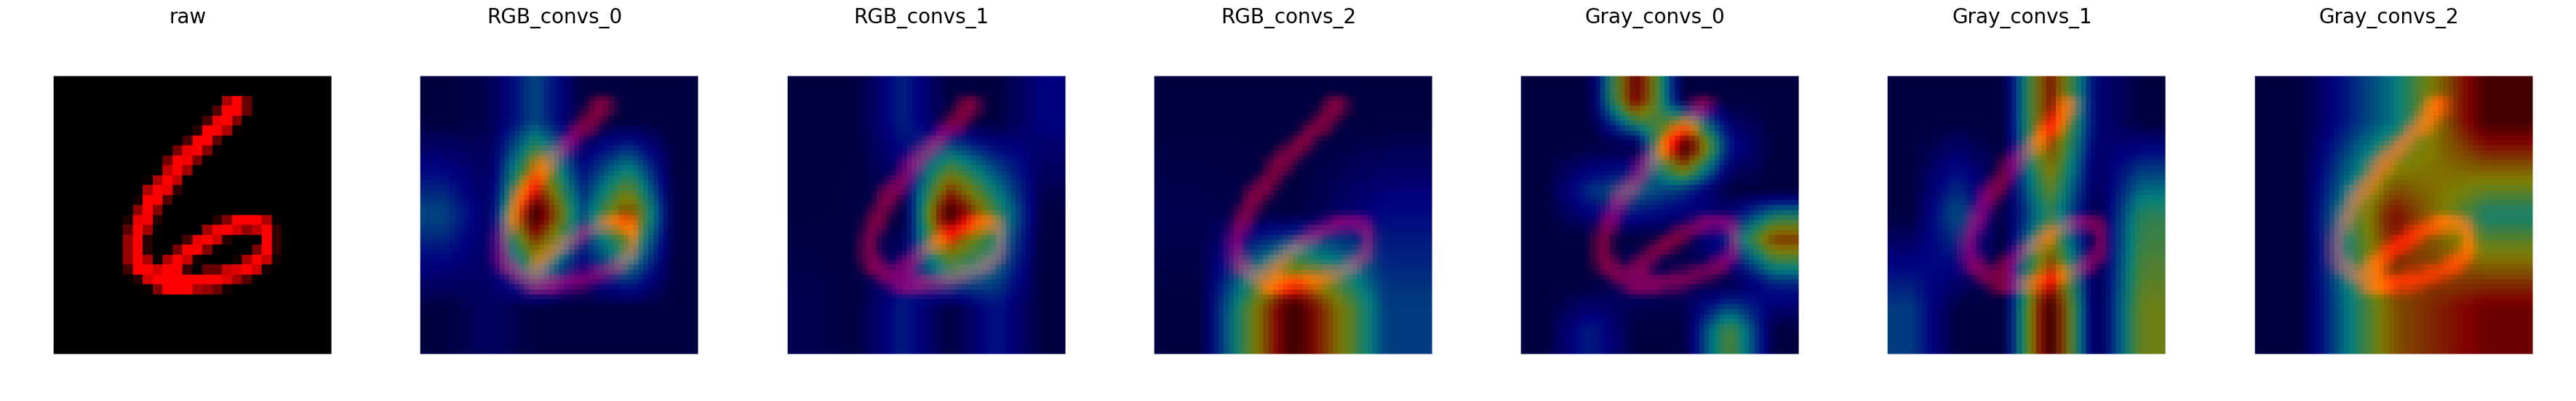


使用方法: GradCAMPlusPlus


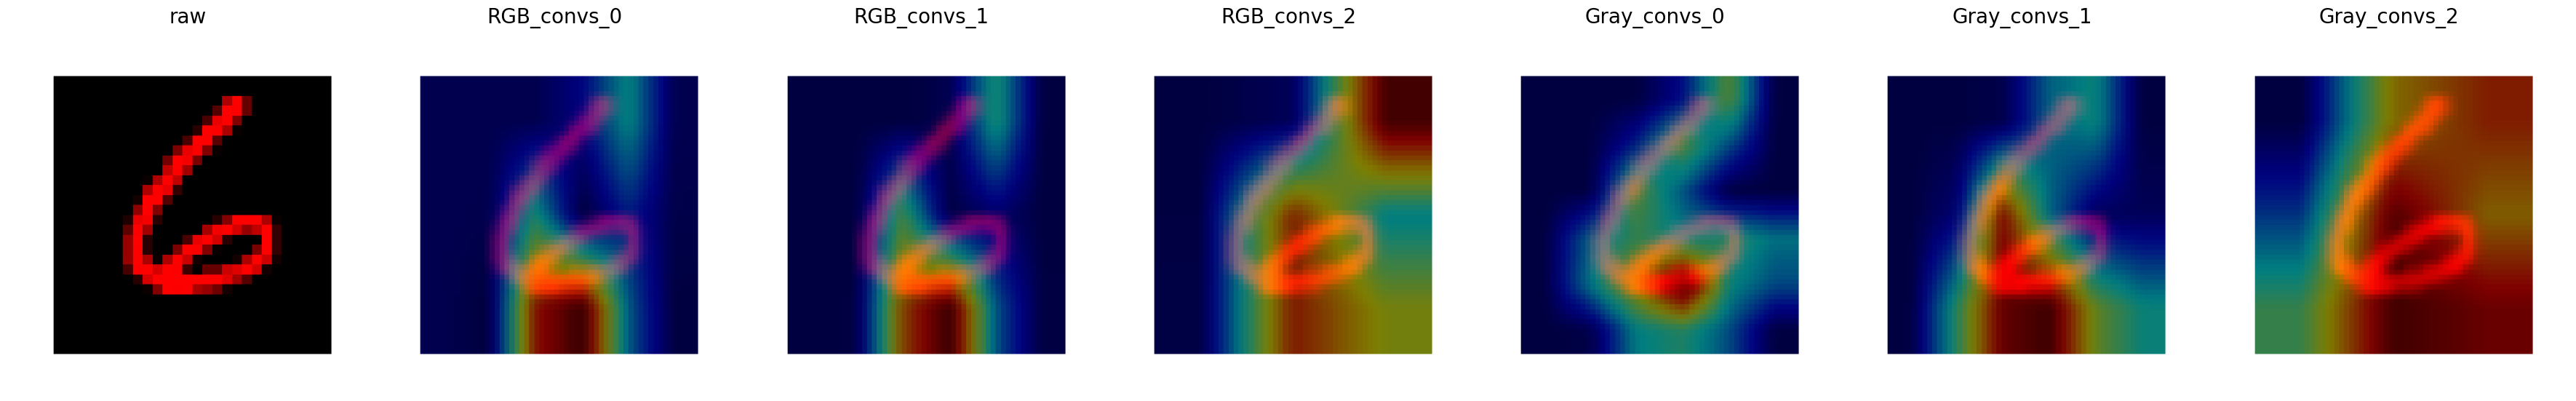


使用方法: GradCAMElementWise


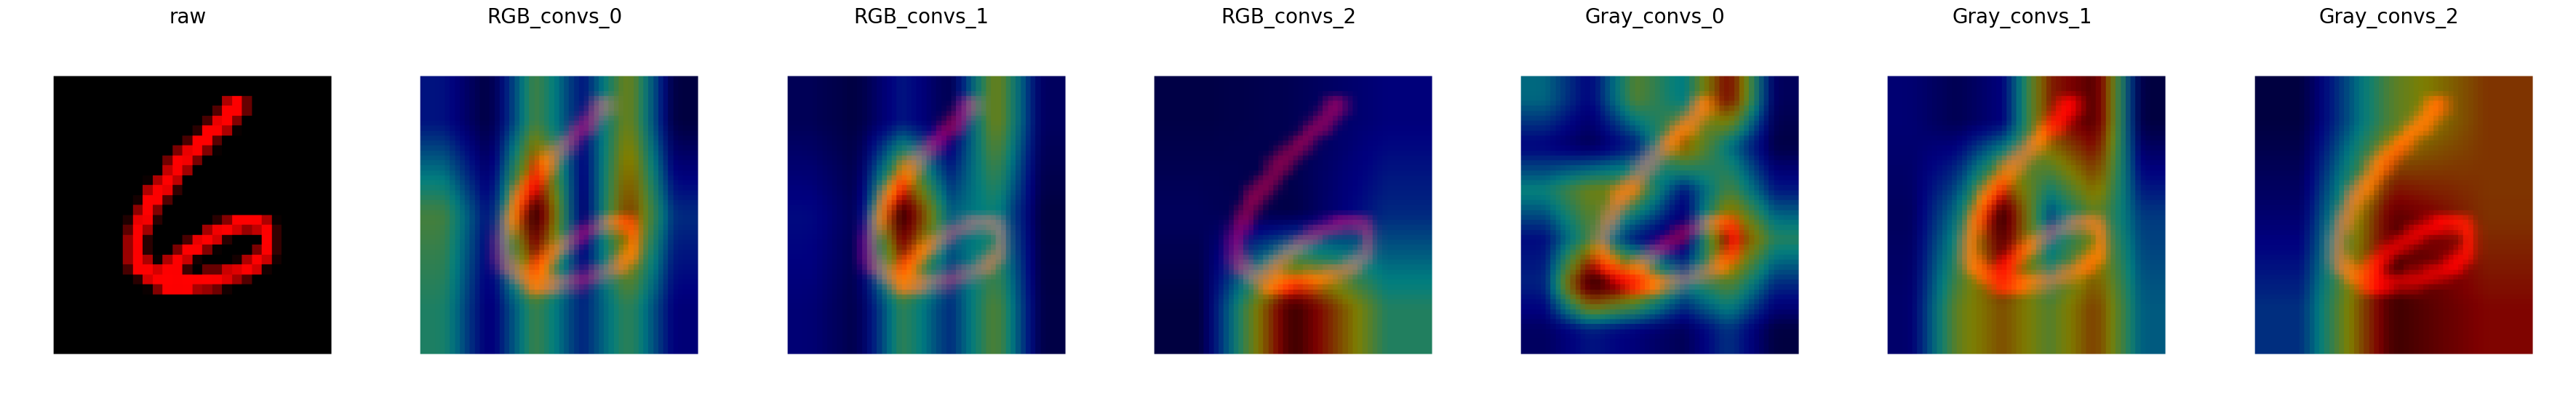


使用方法: XGradCAM


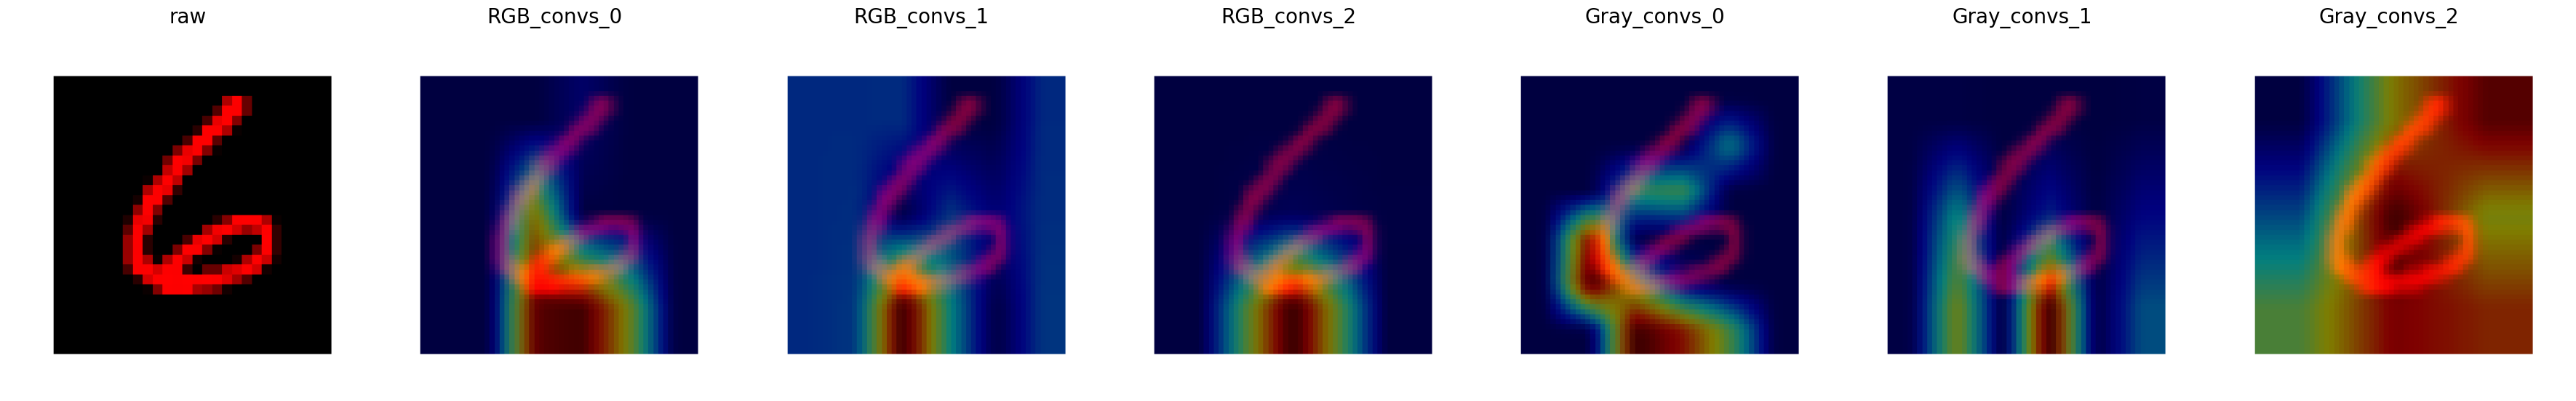


使用方法: AblationCAM


100%|██████████| 39/39 [00:01<00:00, 36.05it/s]


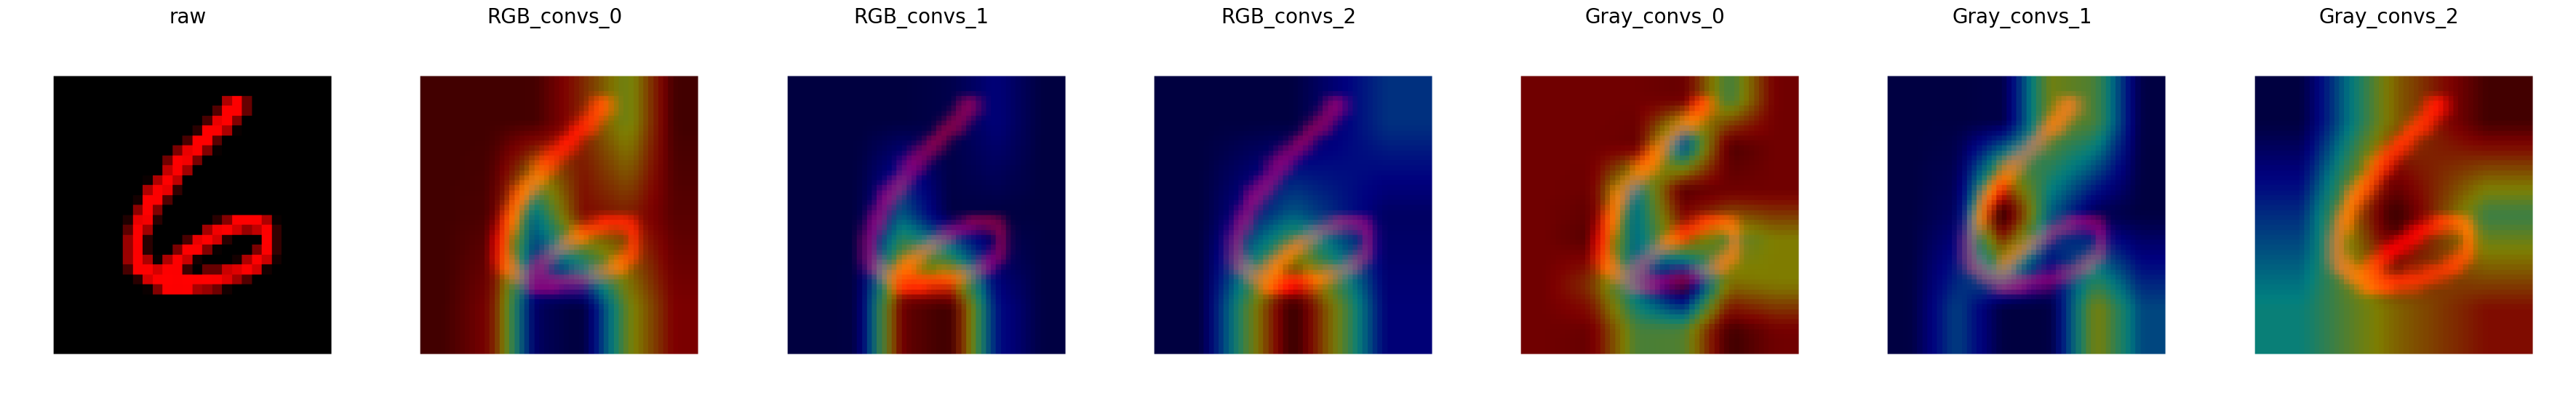


使用方法: ScoreCAM


100%|██████████| 77/77 [00:01<00:00, 45.87it/s]


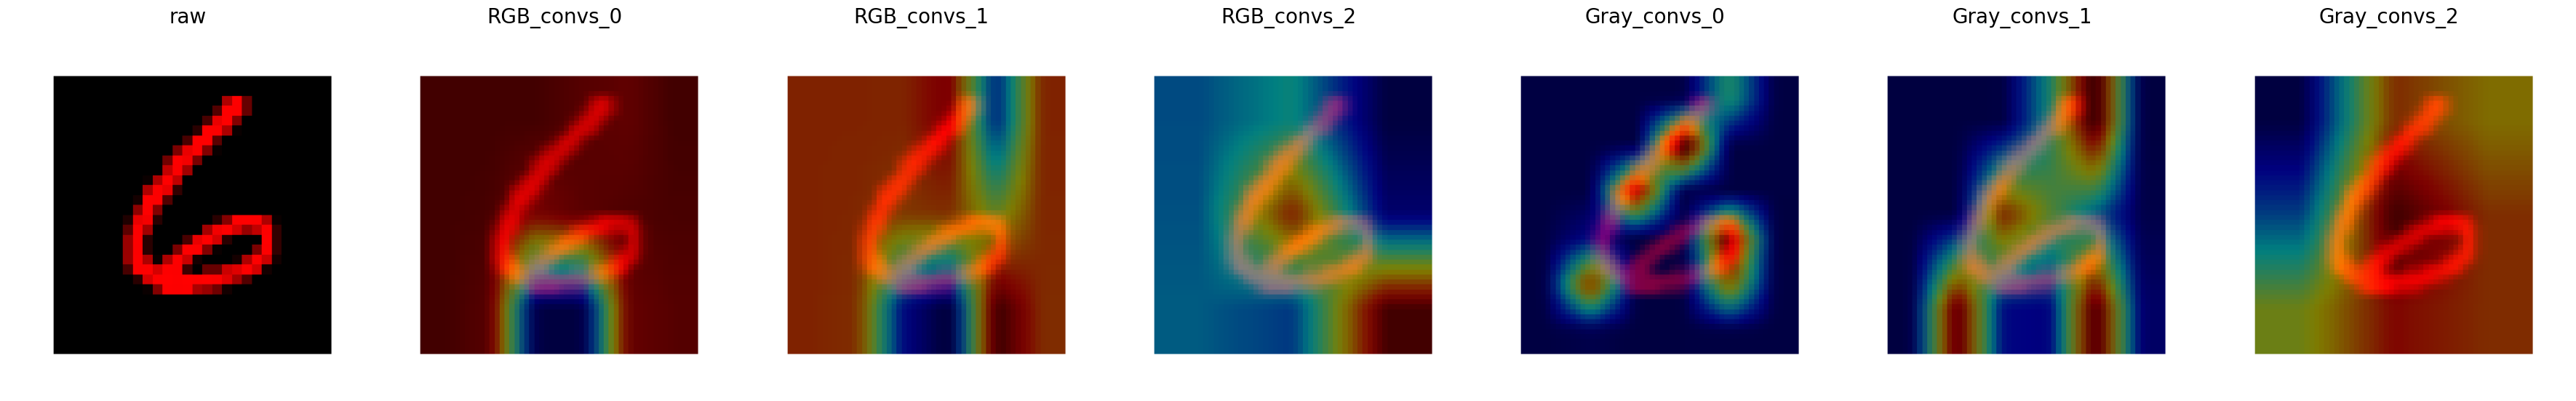


使用方法: EigenCAM


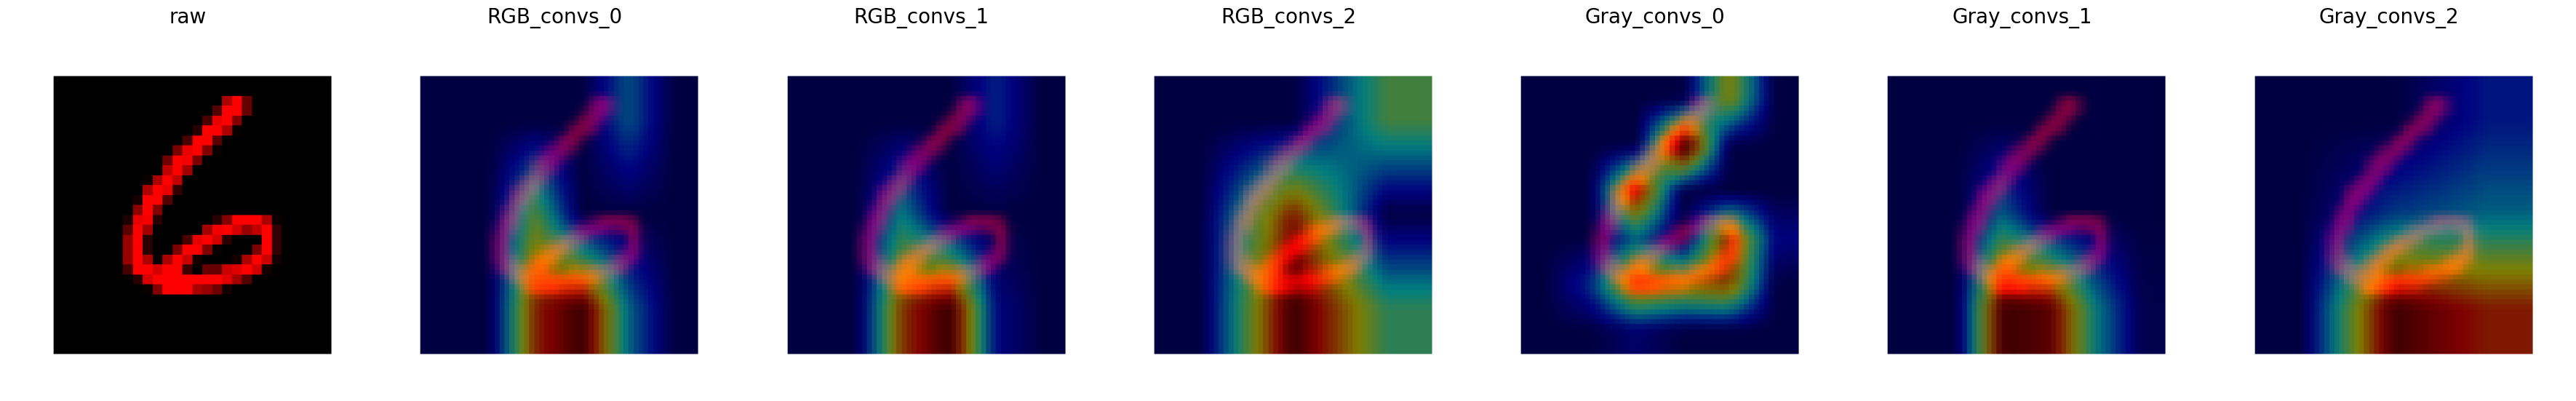


使用方法: EigenGradCAM


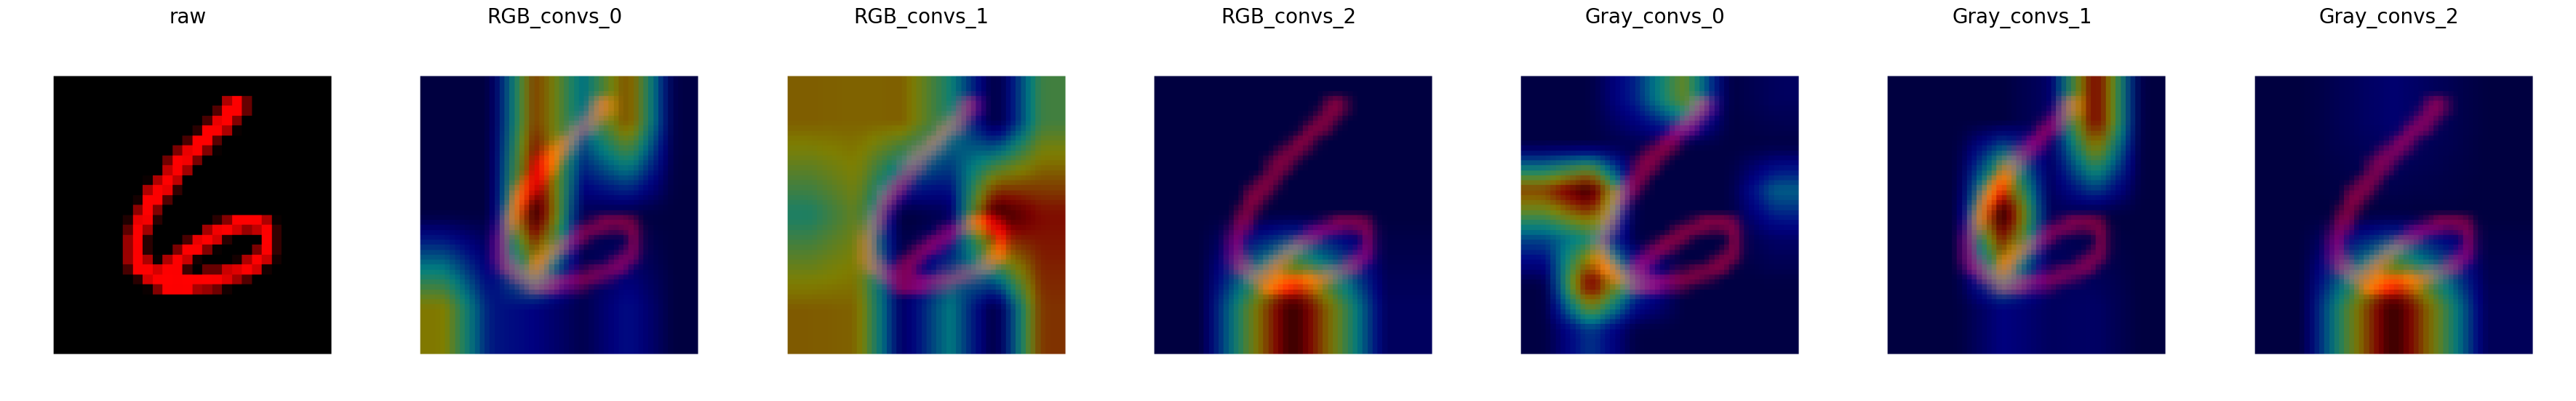


使用方法: LayerCAM


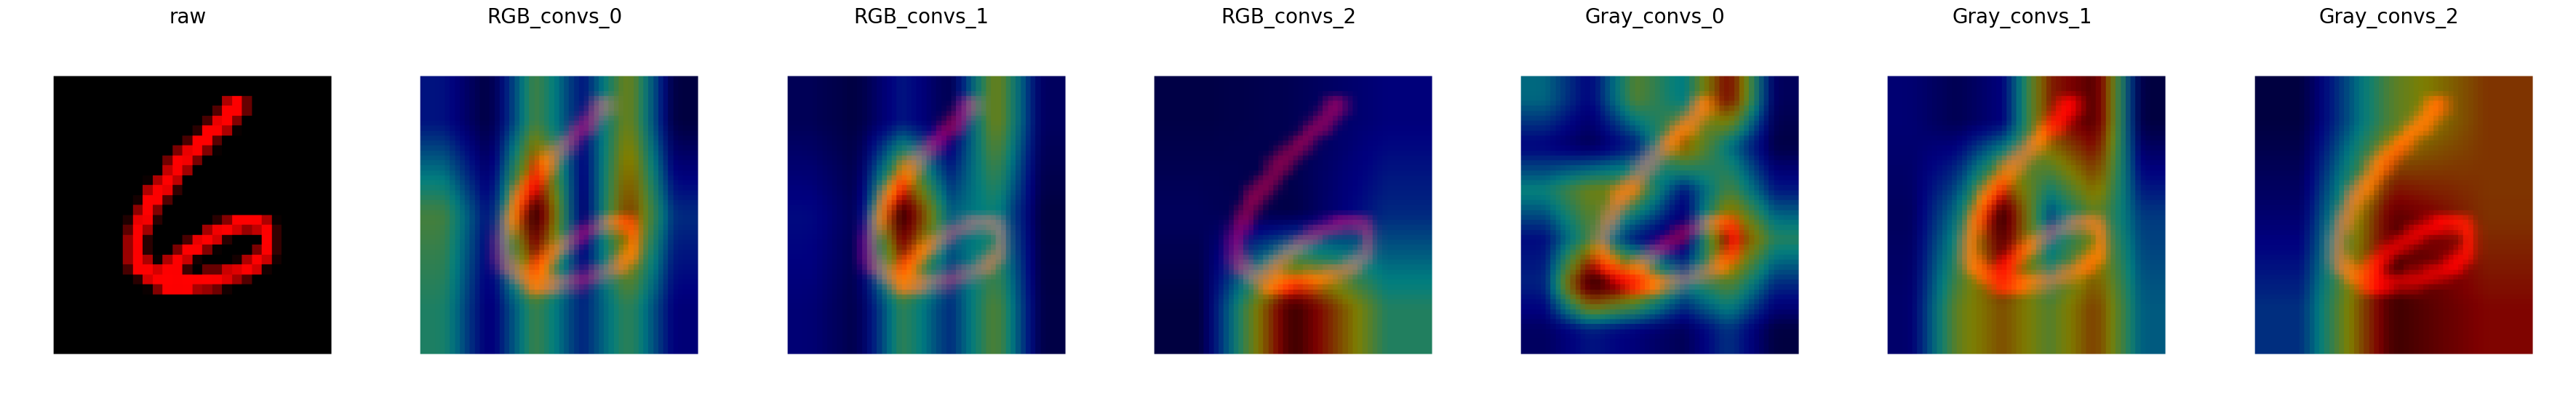


使用方法: KPCA_CAM


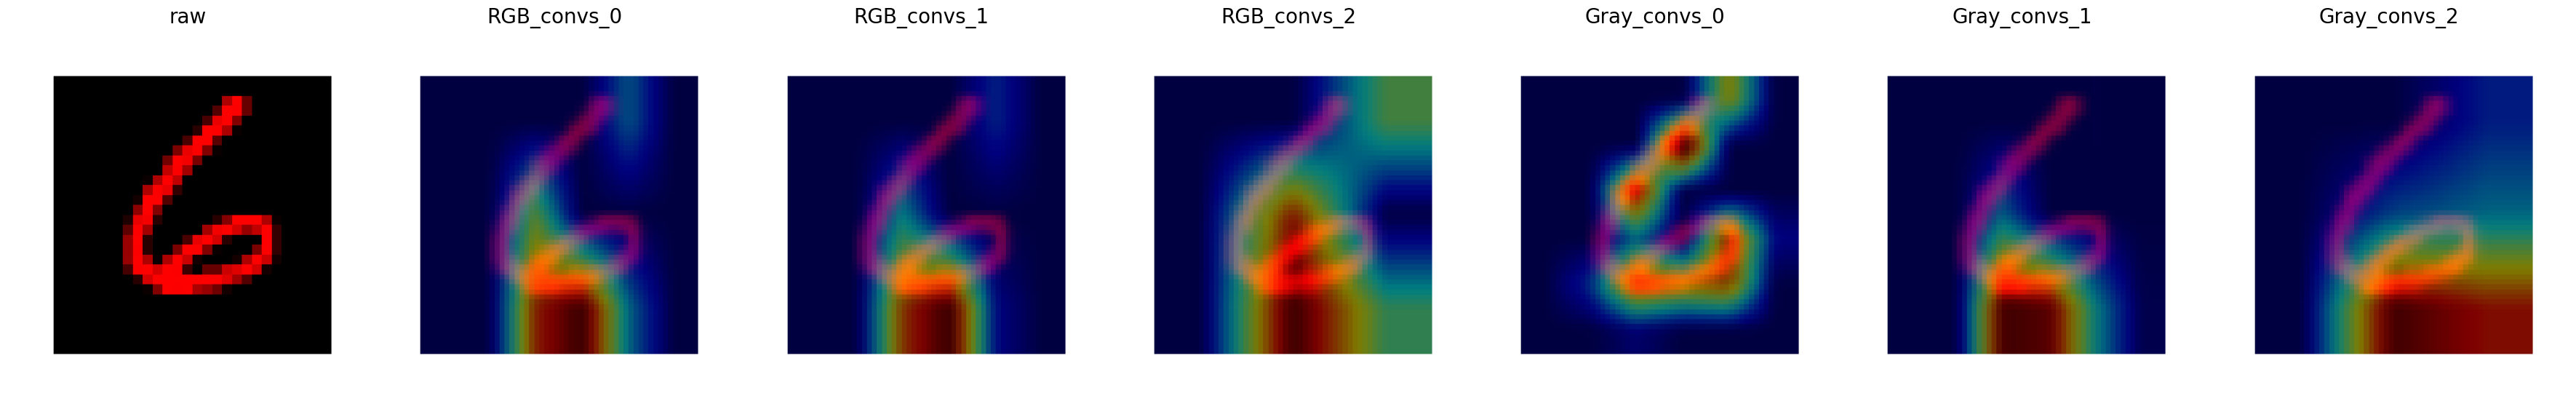

image<class 'torch.Tensor'>

使用方法: GradCAM


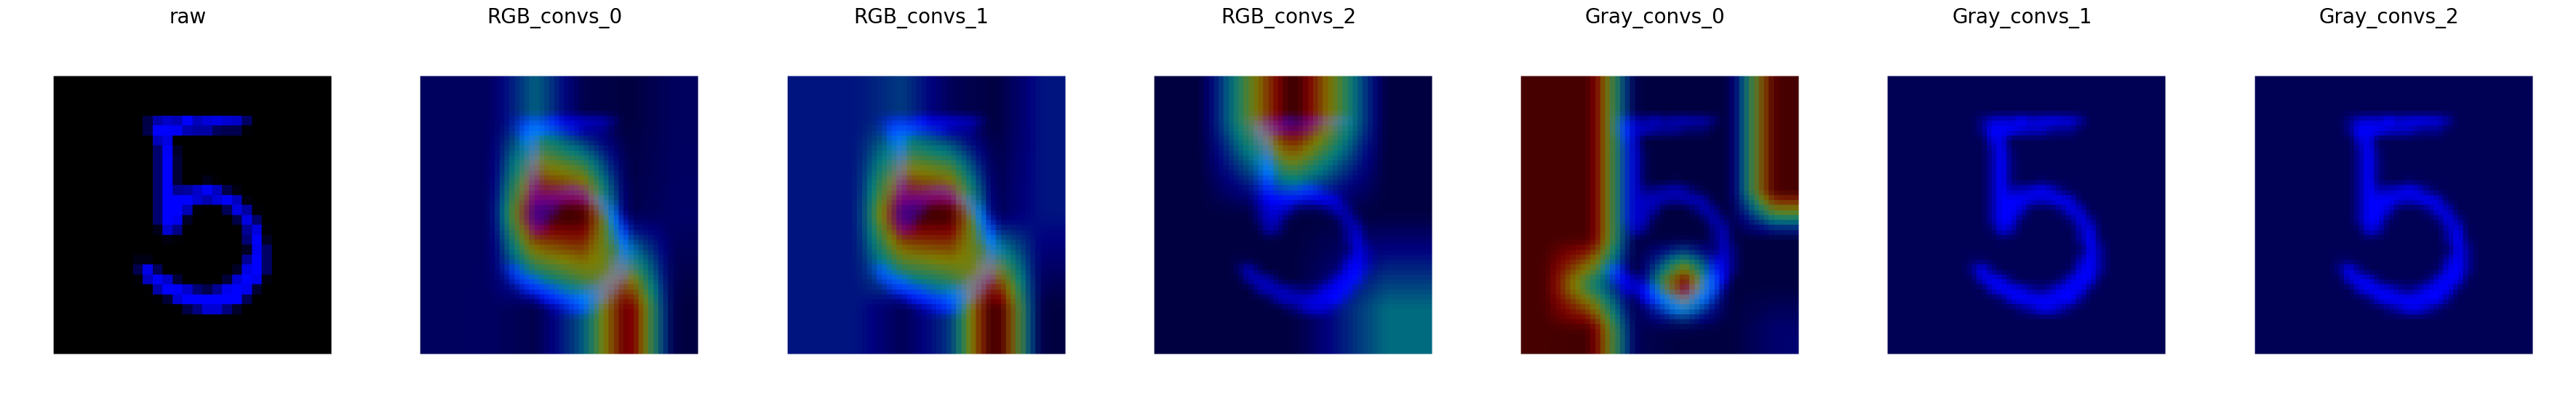


使用方法: HiResCAM


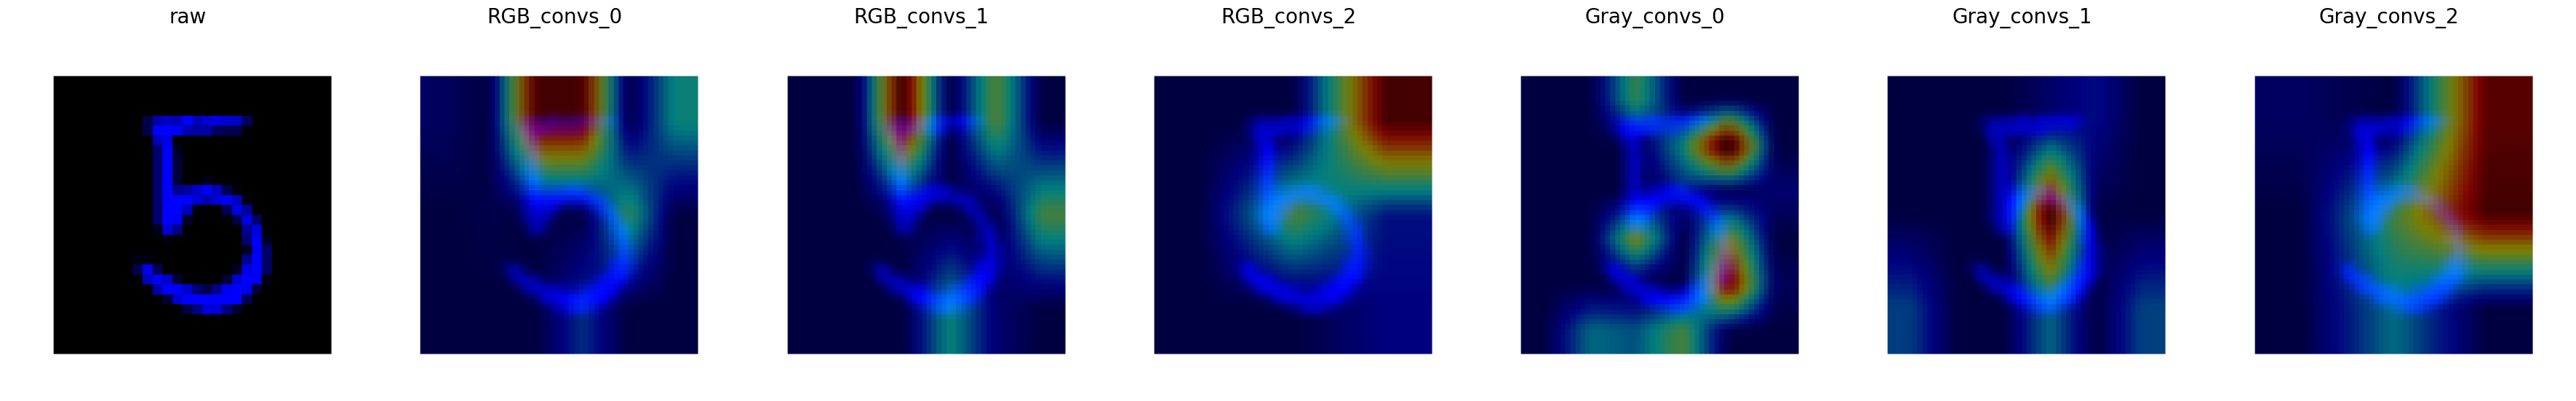


使用方法: GradCAMPlusPlus


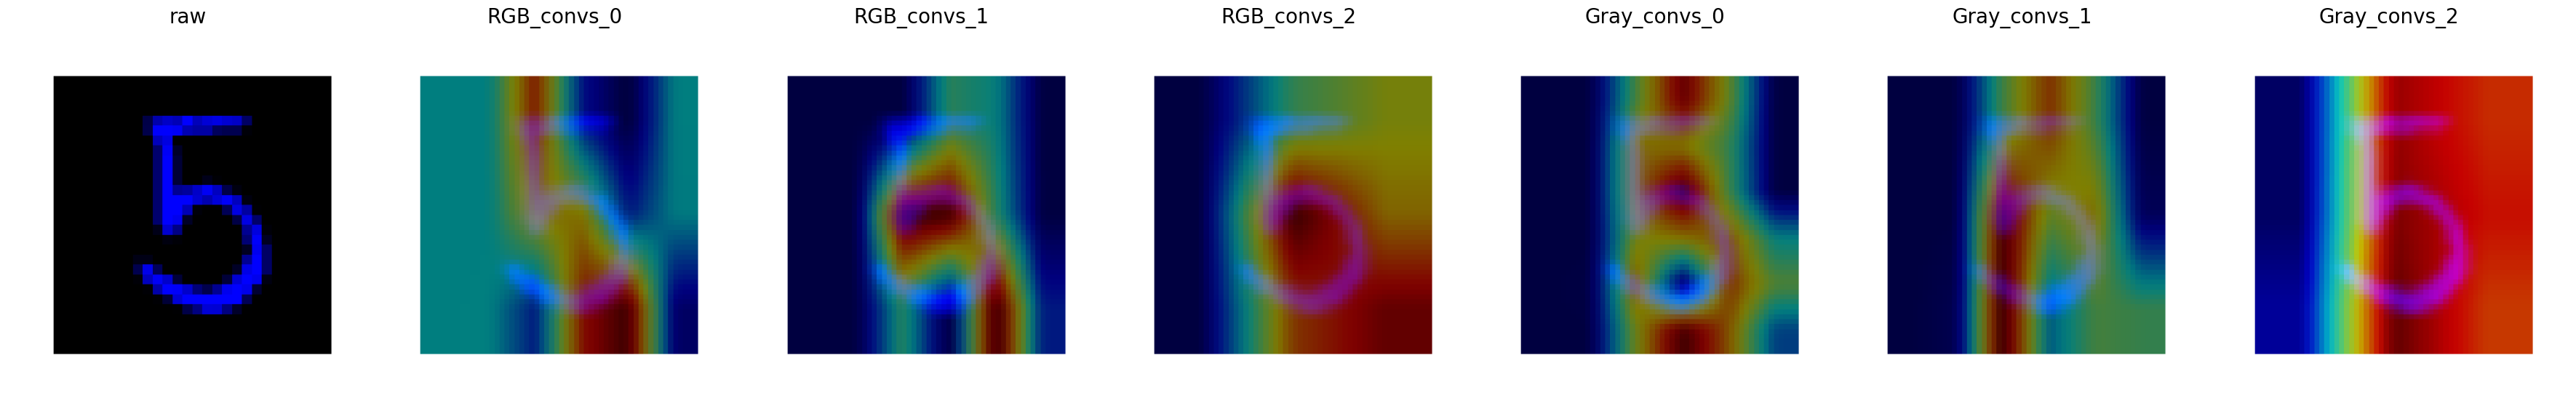


使用方法: GradCAMElementWise


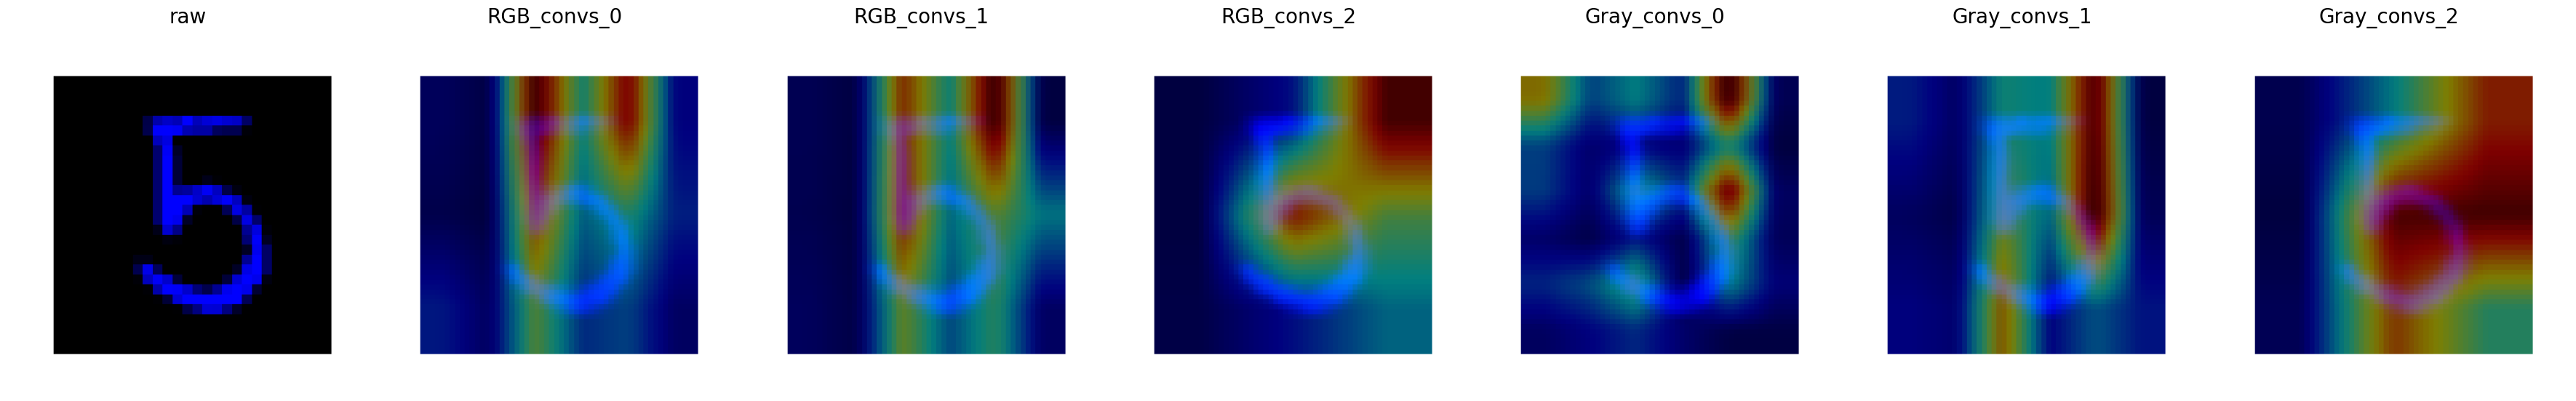


使用方法: XGradCAM


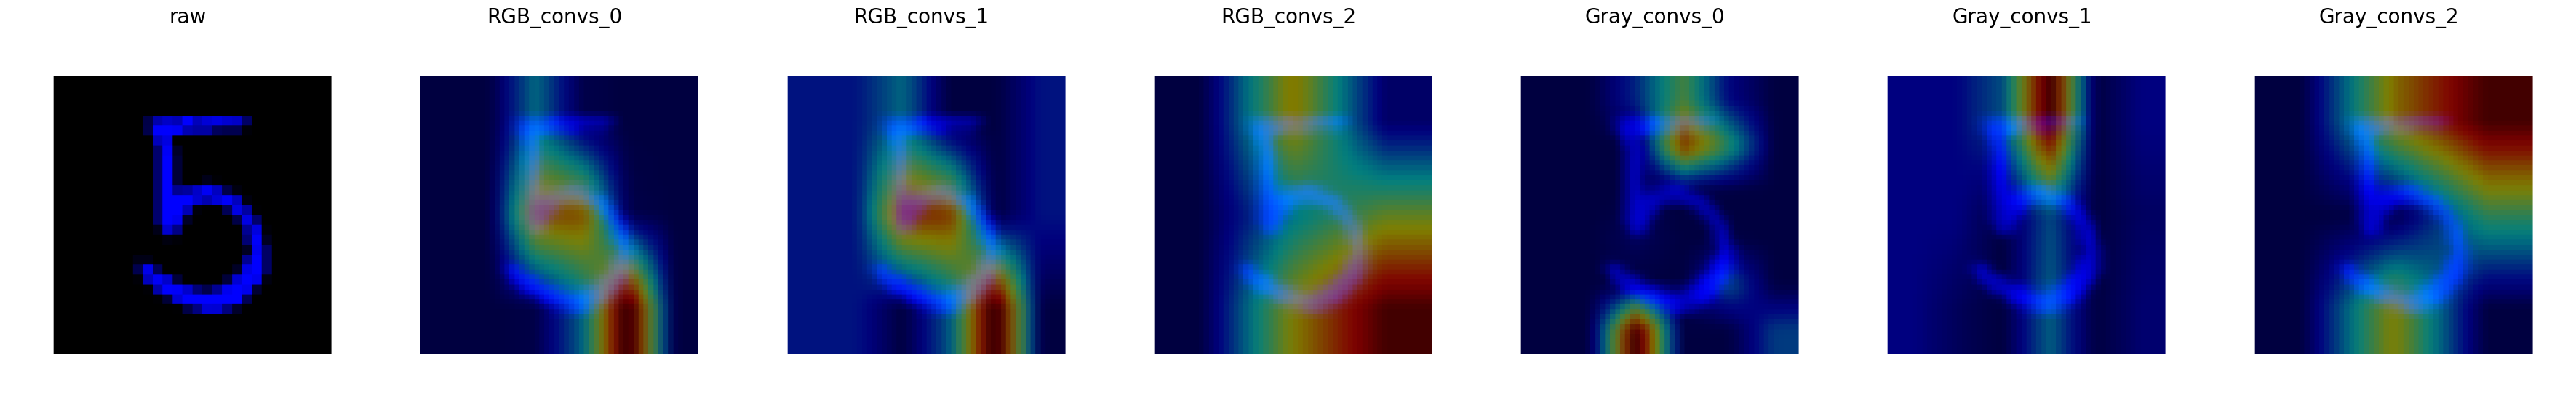


使用方法: AblationCAM


100%|██████████| 39/39 [00:01<00:00, 37.68it/s]


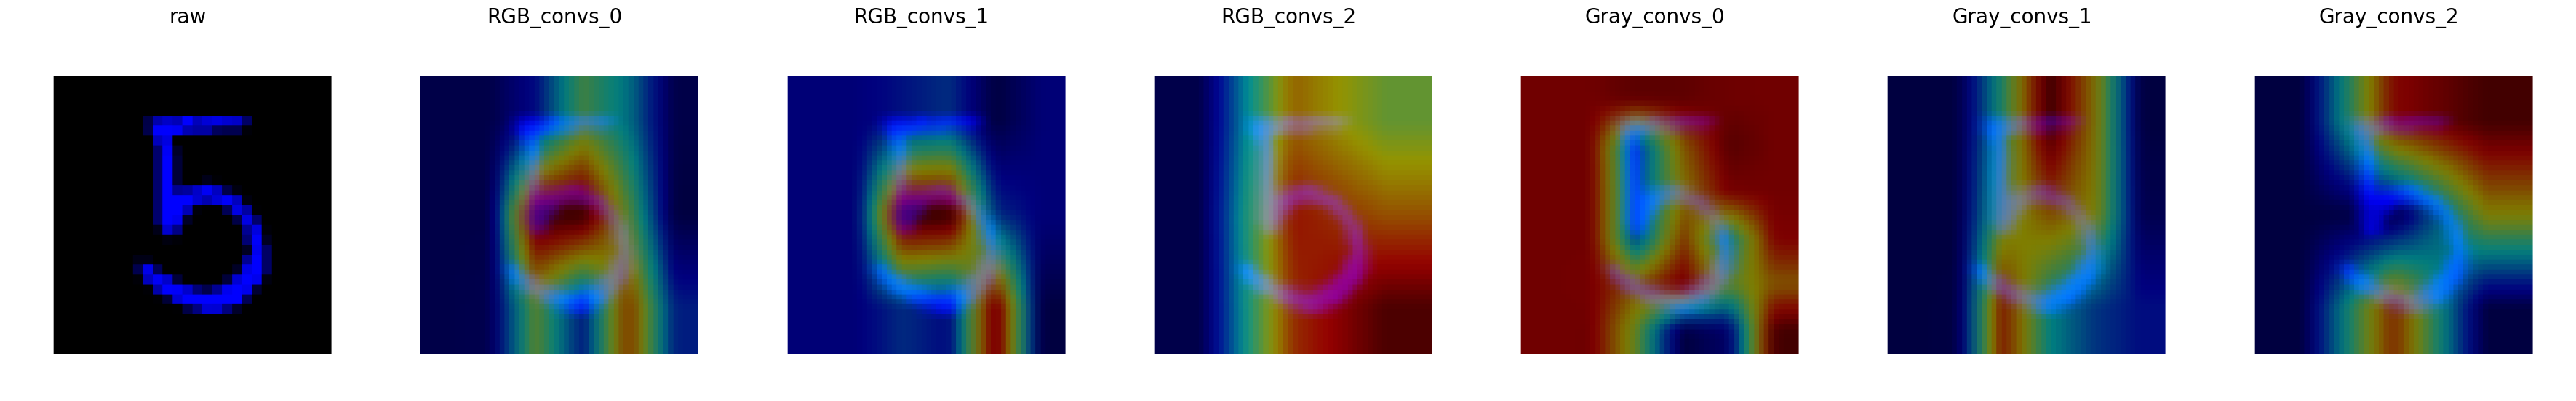


使用方法: ScoreCAM


 97%|█████████▋| 75/77 [00:01<00:00, 42.38it/s]

In [ ]:
from utils import plot_combine_images

# 繪製圖

# save_path = f'./detect/{config["dataset"]}_{checkpoint_filename}/example/{label.argmax().item()}/example_{test_id}/'
save_path = f'./detect/{config["dataset"]}_{checkpoint_filename}/example/'

heatmap_methods = [GradCAM, HiResCAM, GradCAMPlusPlus, GradCAMElementWise, XGradCAM, AblationCAM,
                   ScoreCAM, EigenCAM, EigenGradCAM, LayerCAM, KPCA_CAM]


for i in range(0, 3):
    image = images[i]
    label = labels[i].argmax().item()
    
    heatmap_save = f'{save_path}/{label}/{i}/heatmap/'
    os.makedirs(heatmap_save, exist_ok=True)
    
    
    visualize_all_heatmap(model, heatmap_layers, image, label, save_path, heatmap_methods)
            
    